<h1 align="center">Deep Learning Based Recommenders in Keras</h1>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Embedding,Input,Dense
from keras.layers import Dot,Flatten,Add,Concatenate
from keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline
FILE_PATH = "./data/Movielens/"

Using TensorFlow backend.


## Load the data
The original dataset has been proprocessed to filter out and keep only the top users and items.<br>
Please refer to the preprocessing notebook in the repo for more details.

In [2]:
df_train=pd.read_csv(FILE_PATH+'train.csv')
df_test=pd.read_csv(FILE_PATH+'test.csv')
col_user="userId"
col_item="movieId"
col_rating="rating"

In [3]:
df_train.head(4)

,userId,movieId,rating
0,0,540,3.5
1,0,550,3.0
2,0,340,4.0
3,0,326,3.0


In [4]:
n_users=df_train[col_user].max()+1
n_items=df_train[col_item].max()+1
mean=df_train[col_rating].mean()

## Matrix Factorization

In [5]:
def MF_model(latent_factors,reg):
    
    user_id = Input(shape=(1,))
    item_id = Input(shape=(1,))
     
    user_embed = Embedding(n_users, latent_factors, input_length=1, embeddings_regularizer=l2(reg))(user_id)
    item_embed = Embedding(n_items, latent_factors, input_length=1, embeddings_regularizer=l2(reg))(item_id)
    
    user_bias = Embedding(n_users, 1, input_length=1, embeddings_regularizer=l2(reg), trainable=True)(user_id)
    item_bias = Embedding(n_items, 1, input_length=1, embeddings_regularizer=l2(reg), trainable=True)(item_id)
    
    pred = Dot(axes=2)([user_embed, item_embed])
    
    rating = Add()([pred,user_bias,item_bias])
    rating = Flatten()(rating)
    
    model = Model(inputs=[user_id, item_id ], outputs=rating)
    
    return model

model=MF_model(10,0)
model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])

19258/19258 [==============================] - 1s 56us/step
Train mean squared error 0.4661004813393703
Test mean squared error 0.5843054355150294


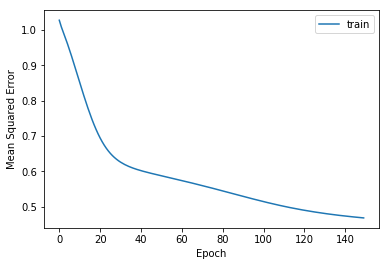

In [6]:
epochs=150
history=model.fit([df_train[col_user],df_train[col_item]], df_train[col_rating]-mean, batch_size=6024, epochs=epochs,verbose=0)

train_error=model.evaluate([df_train[col_user],df_train[col_item]], df_train[col_rating]-mean)
test_error=model.evaluate([df_test[col_user],df_test[col_item]], df_test[col_rating]-mean)
print("Train mean squared error",train_error[0])
print("Test mean squared error",test_error[0])

plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## Deep Model

In [7]:
def Deep_model(latent_factors,reg):
    
    user_id = Input(shape=(1,))
    item_id = Input(shape=(1,))
     
    user_embed = Embedding(n_users, latent_factors)(user_id)
    item_embed = Embedding(n_items, latent_factors)(item_id)
    
    features = Concatenate()([user_embed, item_embed])
    features = Flatten()(features)
    x1 = Dense(5, activation='relu') (features)
    x2 = Dense(5, activation='sigmoid') (x1)
    final = Dense(1,activation='linear') (x2)    
    model = Model(inputs=[user_id, item_id ], outputs=final)
    
    return model

model=Deep_model(10,0)
model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])

19258/19258 [==============================] - 1s 55us/step
Train mean squared error 0.6596139073317427
Test mean squared error 0.6570022641801552


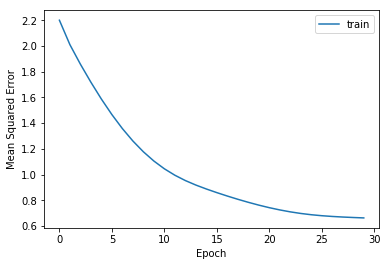

In [8]:
epochs=30
history=model.fit([df_train[col_user],df_train[col_item]], df_train[col_rating]-mean, batch_size=6024, epochs=epochs,verbose=0)

train_error=model.evaluate([df_train[col_user],df_train[col_item]], df_train[col_rating]-mean)
test_error=model.evaluate([df_test[col_user],df_test[col_item]], df_test[col_rating]-mean)
print("Train mean squared error",train_error[0])
print("Test mean squared error",test_error[0])

plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## Residual Learning

In [9]:
def Residual_Model(latent_factors,reg):
    
    user_id = Input(shape=(1,))
    item_id = Input(shape=(1,))
     
    user_embed = Embedding(n_users, latent_factors, input_length=1, embeddings_regularizer=l2(reg))(user_id)
    item_embed = Embedding(n_items, latent_factors, input_length=1, embeddings_regularizer=l2(reg))(item_id)
    
    user_bias = Embedding(n_users, 1, input_length=1, embeddings_regularizer=l2(reg), trainable=True)(user_id)
    item_bias = Embedding(n_items, 1, input_length=1, embeddings_regularizer=l2(reg), trainable=True)(item_id)
    
    ## Matrix Factorixation Block
    pred = Dot(axes=2)([user_embed, item_embed])
    
    rating = Add()([pred,user_bias,item_bias])
    rating = Flatten()(rating)
    
    ## Residual Learning Block
    features = Concatenate()([user_embed, item_embed])
    features = Flatten()(features)
    x1 = Dense(5, activation='relu') (features)
    x2 = Dense(5, activation='sigmoid') (x1)
    final = Dense(1,activation='linear') (x2)
    
    rating = Add()([rating,final])
    model = Model(inputs=[user_id, item_id ], outputs=rating)
    
    return model

model=Residual_Model(10,0)
model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])

19258/19258 [==============================] - 1s 61us/step
Train mean squared error 0.617668522861765
Test mean squared error 0.624568504749373


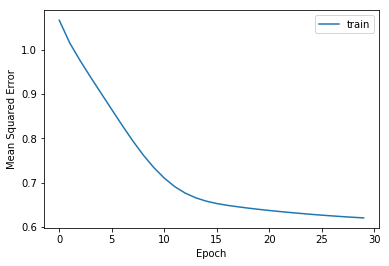

In [10]:
epochs=30
history=model.fit([df_train[col_user],df_train[col_item]], df_train[col_rating]-mean, batch_size=6024, epochs=epochs,verbose=0)

train_error=model.evaluate([df_train[col_user],df_train[col_item]], df_train[col_rating]-mean)
test_error=model.evaluate([df_test[col_user],df_test[col_item]], df_test[col_rating]-mean)
print("Train mean squared error",train_error[0])
print("Test mean squared error",test_error[0])

plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()